In [1]:
import pandas as pd 
import numpy as np 
import datetime as dt 
import matplotlib.pyplot as plt 

import sys 
sys.path.append('../../../')
from bin.main import Manager

m = Manager('../../../')

Options db Connected: 2025-01-30 22:21:59.957995
Prices Connected: 2025-01-30 22:21:59.958584





In [24]:
def get_unique_expirations(stock):
    q = f'''
    select distinct date(expiry) as expiry from {stock} order by date(expiry) asc 
    '''
    return q


exps = m.Optionsdb.option_custom_q(get_unique_expirations('spy'), 'option_db')

exps.expiry = pd.to_datetime(exps.expiry)
exps['code'] = exps.expiry.apply(lambda x: x.strftime('%y%m%d'))
expirations = sorted(exps.expiry.to_list())
exps

,expiry,code
0,2024-04-08,240408
1,2024-04-09,240409
2,2024-04-10,240410
3,2024-04-11,240411
4,2024-04-12,240412
...,...,...
231,2026-03-20,260320
232,2026-06-18,260618
233,2026-12-18,261218
234,2027-01-15,270115


In [31]:
exps[exps['expiry'] > "2025-01-30"]

,expiry,code
206,2025-01-31,250131
207,2025-02-03,250203
208,2025-02-04,250204
209,2025-02-05,250205
210,2025-02-06,250206
211,2025-02-07,250207
212,2025-02-14,250214
213,2025-02-21,250221
214,2025-02-28,250228
215,2025-03-07,250307


In [32]:
def get_expiration_data(stock, expiration):
    q = f'''
    select * from {stock} where contractsymbol like "%{expiration}%"
    '''
    return q

# options data 
code = exps[exps.expiry == expirations[206]].code.iloc[0]
expdf = m.Optionsdb.option_custom_q(get_expiration_data('spy', code), 'change_db')
expdf['moneyness'] = expdf.strike / expdf.stk_price
expdf.gatherdate = pd.to_datetime(expdf.gatherdate)

dtes = (expdf.gatherdate.min().date().strftime('%Y-%m-%d'), expdf.gatherdate.max().date().strftime('%Y-%m-%d'))

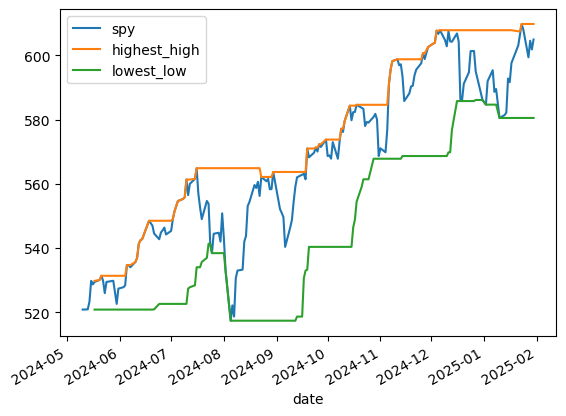

In [33]:
close_prices = m.Pricedb.get_close(['spy'])[dtes[0]:dtes[1]]
close_prices['highest_high'] = close_prices['spy'].rolling(window = 28, min_periods = 6).max()
close_prices['lowest_low'] = close_prices['spy'].rolling(window = 28, min_periods = 6).min()
close_prices.plot()
plt.show()

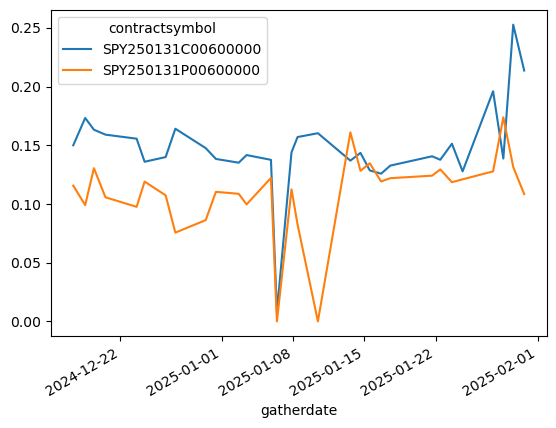

In [35]:
expdf[expdf.strike == 600].groupby(['contractsymbol', 'gatherdate']).impliedvolatility.last().unstack(level=0).tail(30).plot()
plt.show()

<Axes: xlabel='gatherdate'>

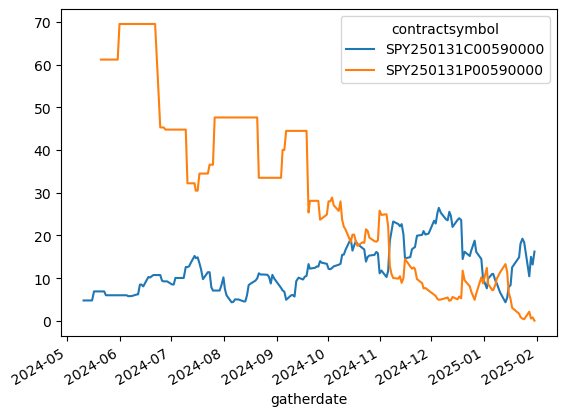

In [36]:
expdf[expdf.strike == 590].groupby(['contractsymbol', 'gatherdate']).lastprice.last().unstack(level=0).plot()